# FIREX-AQ 2 CMAQ
### Grid FIREX-AQ observations to CMAQ grid

Inputs:
* FIREX-AQ data
* Met files
* GRIDDESC file

In [2]:
import PseudoNetCDF as pnc
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
mygrid = '108NHEMI2'

In [4]:
gf = pnc.pncopen('/home/jeast/GRIDDESC',format='griddesc',GDNAM='108NHEMI2')

**PNC:/home/jeast/.conda/envs/jpy01/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  SDATE was -635; using 1970001
**PNC:/home/jeast/.conda/envs/jpy01/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF


In [5]:
# path, can read this from file/command line
pathtofxaq = '../data/MERGES/60_SECOND.DC8_MRG/firexaq-mrg60-dc8_merge_20190722_R1_thru20190905.ict'

In [6]:
fxaq = pnc.pncopen(pathtofxaq,format='ffi1001')

In [7]:
# list all variables and pick ones I want
keepv = []
for v in list(fxaq.variables.keys()):
    #if ('NO' in v) or ('O3' in v):
    if 'RYERSON' in v:
        print(v)
        keepv.append(v)
    if 'CO_' in v and 'DISKIN' in v:
        print(v)
        keepv.append(v)
altitudevar = 'MSL_GPS_Altitude_YANG'
print(keepv)

O3_CL_RYERSON
NO_CL_RYERSON
NO2_CL_RYERSON
NOy_CL_RYERSON
CO_DACOM_DISKIN
['O3_CL_RYERSON', 'NO_CL_RYERSON', 'NO2_CL_RYERSON', 'NOy_CL_RYERSON', 'CO_DACOM_DISKIN']


In [8]:
plumet = 10 # near plume minutes to exclude

In [9]:
m3df = '/work/MOD3EVAL/jeast/NO2ASSIM/CMAQ/input/2019_hemi/mcip/METCRO3D_20190803.nc4'
#m3d = pnc.pncopen(m3df, format='ioapi')
m3d = xr.open_dataset(m3df)

In [10]:
sdate = pd.to_datetime(f'{m3d.SDATE}',format='%Y%j') # assumes STIME = 0

In [11]:
dfx = pd.DataFrame()
dfx['time'] = pd.to_datetime('20190101')+pd.to_timedelta(fxaq.variables['Fractional_Day']-1,unit='D')
dfx['time'] = dfx['time'].dt.round('1min')
dfx['lat'] = fxaq.variables['Latitude_YANG'].array()
dfx['lon'] = fxaq.variables['Longitude_YANG'].array()
dfx['smokeflag'] = fxaq.variables['Smoke_flag_SCHWARZ'].array()
dfx[f'altitude_{fxaq.variables[altitudevar].units}'] = fxaq.variables[altitudevar].array()
for v in keepv:
    dfx[f'{v}_{fxaq.variables[v].units}'] = fxaq.variables[v].array()

In [12]:
dfx['I'],dfx['J'] = gf.ll2ij(dfx['lon'],dfx['lat'])

**PNC:/home/jeast/.conda/envs/jpy01/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  IOAPI_ISPH is assumed to be 6370000.; consistent with WRF


In [13]:
dfx['T'] = np.array([(t - sdate).total_seconds() // 3600 for t in dfx['time']], dtype='i')

In [14]:
dfxd = dfx.query('T >= 0 and T <= 23').copy(deep=True)

In [15]:
dfxd['K'] = np.ma.masked_less(
    m3d['ZF'].values[dfxd['T'],:,dfxd['J'],dfxd['I']] - dfxd['altitude_m'].to_numpy()[:,None],0
).argmin(1)

In [16]:
dfxd['out_plume'] = np.where(dfxd['smokeflag'].isna(),True,False)
dfxd['in_plume'] = ~dfxd['out_plume'].copy(deep=True)

In [17]:
%%time
# find a better way to do this
tinvalid_range = np.array([
    pd.date_range(
        start = dfxd.where(dfxd['in_plume']).dropna()['time'][i]-pd.to_timedelta(f'{plumet}min'),
        end = dfxd.where(dfxd['in_plume']).dropna()['time'][i]+pd.to_timedelta(f'{plumet}min'),
        freq='1min'
    )
    for i in dfxd.where(dfxd['in_plume']).dropna()['time'].index
])

CPU times: user 674 ms, sys: 2.76 ms, total: 676 ms
Wall time: 696 ms


In [20]:
dfx.time.dt.day.unique()

array([22, 23, 24, 25, 26, 29, 30, 31,  2,  3,  4,  6,  7,  8,  9, 12, 13,
       14, 15, 16, 17, 19, 21, 27,  1,  5])

In [17]:
tinvalid = np.unique(tinvalid_range)

In [18]:
dfxd['near_plume'] = dfxd['out_plume'] & dfxd['time'].isin(tinvalid) # all points outside plume but within X minutes of plume

In [19]:
dtmp = dfxd.query('out_plume & ~near_plume').groupby(by=['T','K','J','I']).mean()[[f'{v}_ppbv' for v in keepv]]

In [20]:
# Make data the shape of an ioapi file

blankij=pd.DataFrame(
    np.zeros((24*44*187*187)),
    columns=['blank'],
    index=pd.MultiIndex.from_product(
        [
            np.arange(0,24,dtype=int),
            np.arange(0,44,dtype=int),
            np.arange(0,187,dtype=int),
            np.arange(0,187,dtype=int)
        ],
        names=['T','K','J','I']
    ),
)

dfout = (
    blankij.drop(['blank'],axis='columns')
).merge(
    dtmp,
    how='outer',
    left_index=True,
    right_on=['T','K','J','I']
)
dout = dfout.to_xarray()

In [21]:
# open an IOAPI for a template
fakeioapi = '/work/MOD3EVAL/jeast/NO2ASSIM/manuscript/figure_data/IOAPI.FAKE.nc'
ioapif = pnc.pncopen(m3df, format='ioapi')

In [22]:
# create template
tmpf = ioapif.subsetVariables(['ZF']).copy()
tmpf.TSTEP = 10000
setattr(tmpf,'SDATE',int(sdate.strftime('%Y%j')))
tmpf.updatetflag(overwrite=True)
outf = tmpf.sliceDimensions(TSTEP=slice(0,24))

In [23]:
# make variable in new file
for v in dout.data_vars: 
    evar = outf.createVariable(v, 'f', ('TSTEP', 'LAY', 'ROW', 'COL'))
    evar.setncatts(dict(
      units=v.split('_')[-1], long_name=v, var_desc=f'FIREX-AQ variable f{v} from {pathtofxaq.split("/")[-1]}'
    ))
    evar[:] = dout[v].data

In [24]:
# Get rid of FAKE file variables
del(outf.variables['ZF'])

# Update TFLAG to be consistent with variables
outf.updatetflag(tstep=240000, overwrite=True)

# Remove VAR-LIST so that it can be inferred
delattr(tmpf, 'VAR-LIST')
setattr(outf,'VAR-LIST','    '.join([v for v in dout.data_vars]))
outf.updatemeta()
setattr(outf,'FILEDESC',f'FIREX-AQ gridded to CMAQ {mygrid}')

# save the file to disk
#outf.save(f'FIREX-AQ.{mygrid}.{sdate.strftime("%Y%m%d")}-test.nc', format='NETCDF4_CLASSIC')

**PNC:/home/jeast/.conda/envs/jpy01/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  O3_CL_RYERSON_ppbv name is too long (18); not included in VAR-LIST
**PNC:/home/jeast/.conda/envs/jpy01/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  NO_CL_RYERSON_ppbv name is too long (18); not included in VAR-LIST
**PNC:/home/jeast/.conda/envs/jpy01/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  NO2_CL_RYERSON_ppbv name is too long (19); not included in VAR-LIST
**PNC:/home/jeast/.conda/envs/jpy01/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  NOy_CL_RYERSON_ppbv name is too long (19); not included in VAR-LIST
**PNC:/home/jeast/.conda/envs/jpy01/lib/python3.9/site-packages/PseudoNetCDF/pncwarn.py:24:UserWarning:
  CO_DACOM_DISKIN_ppbv name is too long (20); not included in VAR-LIST


Adding dimensions
Adding globals
Adding variables
Defining O3_CL_RYERSON_ppbv
Defining NO_CL_RYERSON_ppbv
Defining NO2_CL_RYERSON_ppbv
Defining NOy_CL_RYERSON_ppbv
Defining CO_DACOM_DISKIN_ppbv
Defining TFLAG
Populating O3_CL_RYERSON_ppbv
Populating NO_CL_RYERSON_ppbv
Populating NO2_CL_RYERSON_ppbv
Populating NOy_CL_RYERSON_ppbv
Populating CO_DACOM_DISKIN_ppbv
Populating TFLAG


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDATE: 2020338
    CTIME: 201225
    WDATE: 2022221
    WTIME: 132134
    IOAPI_VERSION: ioapi-3.2: $Id: init3.F90 1 2017-06-10 18:05:20Z coats $                        
    EXEC_ID: mcip                                                                            
    FTYPE: 1
    SDATE: 2019215
    STIME: 0
    TSTEP: 240000
    NTHIK: 1
    NCOLS: 187
    NROWS: 187
    NLAYS: 44
    NVARS: 5
    GDTYP: 6
    P_ALP: 1.0
    P_BET: 45.0
    P_GAM: -98.0
    XCENT: -98.0
    YCENT: 90.0
    XORIG: -10098000.0
    YORIG: -10098000.0
    XCELL: 108000.0
    YCELL: 108000.0
    VGTYP: -9999
    VGTOP: 5000.0
    VGLVLS: [1.     0.9975 0.9946 0.9913 0.9875 0.9831 0.9781 0.9723 0.9657 0.958
 0.9492 0.9391 0.9275 0.9141 0.8987 0.881  0.8607 0.8373 0.8104 0.7795
 0.7439 0.7066 0.6693 0.632  0.5946 0.5573 0.52   0.4827 0.4454 0.4081
 0.3708 0.3352 0.3013 0.269  0.2383 0.2089 0.181  0.1543 0.1289 0.

In [31]:
# test a file

In [39]:
import pycno
import pyproj


proj = pyproj.Proj(
  (
    '+proj=stere +lat_0=90 +lat_ts=45 +lon_0=-98 ' +
    '+x_0=10098000 +y_0=10098000 +R=6370000 +to_meter=108000 ' +
    '+no_defs'
  ),
  preserve_units=True
)


Text(0.5, 1.02, 'FIREX-AQ DC-8\n2019-08-03')

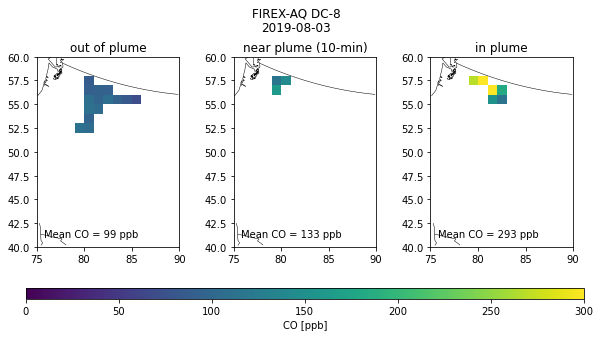

In [91]:
op = xr.open_dataset('./gridded/FIREX-AQ.108NHEMI2.outofplume.20190803.compressed.nc')
cp = xr.open_dataset('./gridded/FIREX-AQ.108NHEMI2.nearplume.20190803.compressed.nc')
ip = xr.open_dataset('./gridded/FIREX-AQ.108NHEMI2.inplume.20190803.compressed.nc')
fig,ax = plt.subplots(1,3,figsize=(10,5))
pc = ax[0].pcolormesh(
    np.ma.masked_less_equal(op['CO_DACOM_DISKIN_ppbv'].mean(('TSTEP','LAY')),0),
    vmin=0,vmax=300
)
pc = ax[1].pcolormesh(
    np.ma.masked_less_equal(cp['CO_DACOM_DISKIN_ppbv'].mean(('TSTEP','LAY')),0),
    vmin=0,vmax=300
)
pc = ax[2].pcolormesh(
    np.ma.masked_less_equal(ip['CO_DACOM_DISKIN_ppbv'].mean(('TSTEP','LAY')),0),
    vmin=0,vmax=300
)
cno = pycno.cno(proj=proj, xlim=(75, 90), ylim=(40, 60))
for axx in ax:
    cno.draw(ax=axx)
    axx.set_aspect('equal')

for axx,da in zip(ax,[op,cp,ip]):
    axx.text(0.05,0.05,f'Mean CO = {da["CO_DACOM_DISKIN_ppbv"].mean().values:.0f} ppb',transform=axx.transAxes)
fig.colorbar(pc,label='CO [ppb]',orientation='horizontal',ax=ax,aspect=50)
ax[0].set_title('out of plume')
ax[1].set_title('near plume (10-min)')
ax[2].set_title('in plume')
fig.suptitle('FIREX-AQ DC-8\n2019-08-03',y=1.02)